In [ ]:
from google.colab import drive
import pandas as pd
import glob
import sqlite3
import scipy.stats  as stats
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [ ]:
drive.mount('/content/drive')
%cd '/content/drive/Shared drives/C2ST_CommunityCorpsW21/DataAnalysis-SharedFolder'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1qAC2LEAd_wBx08vbq4DzJhyCxfzsd6mq/Data Analysis- Shared Folder


# 1. programs_attendance_revised

## 1.1 Data Manipulation(copy from data cleaning colab)

In [ ]:
%cd '/content/drive/Shared drives/C2ST_CommunityCorpsW21/DataAnalysis-SharedFolder/Engagement Data/'
program_df = pd.read_excel('Programs Attendance revised 9.23.20.xlsx')

# Drop unneccessary rows
# Easiest way: program_df[:277] --> need to update slicing when new data comes in
program_df = program_df.dropna(subset=['Date'])
program_df = program_df[~program_df['Date'].str.contains('July',na=False)]
program_df = program_df[~program_df['Date'].str.contains('Total',na=False)]
program_df = program_df[~program_df['Date'].str.contains('Mean',na=False)] 
# Format Date of program 'Energy Colloquium': 5/5&7/08 -> 5/5/08, 5/7/08
program_df=program_df.loc[:,~program_df.columns.str.contains('^Unnamed', case=False)]
format_date = program_df[program_df['Date']=='5/5&7/08']    
format_date.at[4, 'Date'] = '5/7/08'
program_df = pd.concat([program_df, format_date], ignore_index=True)
program_df.at[4,'Date'] = '5/5/08'
# Rename Program Title
program_df['Program Title']= program_df['Program Title'].str.strip()
program_df.at[program_df[program_df['Program Title'] == 'Women in STEM: Connect'].index[0],'Program Title']='2014 Women in STEM'
program_df.at[program_df[program_df['Program Title'] == '2015 Women in STEM: Connect'].index[0],'Program Title']='Women in STEM: Connect 2015'
program_df.at[program_df[program_df['Program Title'] == 'An Evening into the Multiverse'].index[0],'Program Title']='An Evening Inside the Multiverse'
program_df['Date'] = pd.to_datetime(program_df['Date'])
# Create program_id
program_df['Program ID'] = program_df.index
program_df['Program ID'] = 'Program_' + program_df['Program ID'].astype(str)
program_df.loc[program_df['Date'] == '2008-05-07', 'Program ID'] = 'Program_4'

/content/drive/.shortcut-targets-by-id/1qAC2LEAd_wBx08vbq4DzJhyCxfzsd6mq/Data Analysis- Shared Folder/Engagement Data


##1.2 Analysis: 
### 1.2.1 Is there any correlation between live stream and attendence number


#### Fail to reject the null hypothesis(p-value 0.31>0.05). There is no relationship between whether live stream and the number of attendence. 

In [ ]:
for live in program_df['Live Stream']:
  if live !='NaN' or live!=0:
    program_df.loc[program_df['Live Stream']==live,'live_stream'] = 1
program_df['live_stream'] = program_df['live_stream'].fillna(0)
program_df = program_df[program_df['Attendance (in seats)'].notna()]
correlation= stats.pearsonr(program_df['Attendance (in seats)'].astype('float64'),program_df['live_stream'].astype('float64'))
print(correlation)

(0.06375914700870972, 0.3076388333812136)


# 2. Youtube
## 2.1 Data Manipulation(copy from data cleaning colab)

In [ ]:
# Step1
path =r'/content/drive/Shared drives/C2ST_CommunityCorpsW21/TestFiles/Youtube_monthly/Youtube_views'
youtube_view_files = glob.glob(path + "/*.csv")

# 1.Loop through csv files under Youtube_views folder 
# 1) read them into DataFrames 
# 2) create column: Update Time 
youtube_view_dataframes = []
view_start_date = datetime.date(2020, 2, 1)

max_len = 0
for file in youtube_view_files:
  if len(file) > max_len: max_len = len(file) 

for file in youtube_view_files:
  if len(file) == max_len:
    year = int(file[-14:-10])
    month = int(file[-9:-7])
    date = int(file[-6:-4])
    view_start_date = datetime.date(year, month, date)
  else:
    year = int(file[-13:-9])
    month = int(file[-8:-7])
    date = int(file[-6:-4])
    view_start_date = datetime.date(year, month, date)
  view_df = pd.read_csv(file)
  view_df['Update Date'] = view_start_date
  youtube_view_dataframes.append(view_df)

# Concatenate all data into one DataFrame
youtube_view_df = pd.concat(youtube_view_dataframes)
youtube_view_df = youtube_view_df.drop(columns=['% Δ'])
# youtube_view_df

##########################################################
# Step2
path =r'/content/drive/Shared drives/C2ST_CommunityCorpsW21/TestFiles/Youtube_monthly/Youtube_watchtimes' ## Directory needs to change
youtube_length_files = glob.glob(path + "/*.csv")

# Loop through csv files under Youtube_watchtimes folder
# 1) read them into DataFrames 
# 2) create column: Update Time 
youtube_length_dataframes = []
length_start_date = datetime.date(2020, 2,1)

max_len2 = 0
for file in youtube_length_files:
  if len(file) > max_len2: max_len2 = len(file) 

for file in youtube_length_files:
  if len(file) == max_len2:
    year = int(file[-14:-10])
    month = int(file[-9:-7])
    date = int(file[-6:-4])
    length_start_date = datetime.date(year, month, date)
  else:
    year = int(file[-13:-9])
    month = int(file[-8:-7])
    date = int(file[-6:-4])
    length_start_date = datetime.date(year, month, date)
  length_df = pd.read_csv(file)
  length_df['Update Date'] = length_start_date
  youtube_length_dataframes.append(length_df)

# Concatenate all data into one DataFrame
youtube_length_df = pd.concat(youtube_length_dataframes, ignore_index=True)
youtube_length_df = youtube_length_df.drop(columns=['% Δ'])

##########################################################
# Step3: Merge youtube_view_df and youtube_length_df on 'Video Tile' and 'Update Date'
youtube_studio_df = pd.merge(youtube_view_df,youtube_length_df,how="outer", on=["Video Title", "Update Date"])
youtube_studio_df['Update Date'] = pd.to_datetime(youtube_studio_df['Update Date'])

##########################################################
# Step4: Add Publish Date
%cd '/content/drive/Shared drives/C2ST_CommunityCorpsW21/DataAnalysis-SharedFolder/YouTube'
youtube_df = pd.read_csv('Table data.csv')
youtube_df = youtube_df[['Video','Video title','Video publish time']]
youtube_df = youtube_df.dropna(subset=['Video title'])
for video in youtube_studio_df['Video Title']:
  for video2 in youtube_df['Video title']:
    if video == video2:
      date = youtube_df.loc[youtube_df['Video title'] == video2]['Video publish time'].values[0]
      youtube_studio_df.loc[youtube_studio_df['Video Title'] == video, 'Publish Date'] = date
youtube_studio_df['Publish Date'] = pd.to_datetime(youtube_studio_df['Publish Date'])

/content/drive/.shortcut-targets-by-id/1qAC2LEAd_wBx08vbq4DzJhyCxfzsd6mq/Data Analysis- Shared Folder/YouTube


In [ ]:
youtube_studio_df

,Video Title,Views,Update Date,Video Length,Watch Time,Publish Date
0,The Origins of Genus Homo,473,2021-03-25,4661,1309.061815,2018-06-18
1,COVID Vaccines: Fact vs. Fiction,221,2021-03-25,2897,1422.211903,NaT
2,Biomechanics of Running: The Science of Moveme...,153,2021-03-25,4858,748.117743,2014-09-13
3,Mental Help: Coping with Bias & Collective Trauma,124,2021-03-25,3673,1146.804989,NaT
4,"Dietary Supplements: Stories of Regulation, Sa...",88,2021-03-25,5036,288.348500,2017-06-26
...,...,...,...,...,...,...
2518,Climate Disruption: What We Can Do Now,1,2020-01-31,4845,59.935000,2016-03-10
2519,The Science of Star Wars Highlights,1,2020-01-31,155,55.328500,2019-04-11
2520,Music - There's a Science to That Highlights -...,1,2020-01-31,271,3.132000,2015-04-20
2521,"C2ST and 2Blades Present: Food Evolution, High...",0,2020-01-31,344,0.000000,2019-01-07


## 2.2 Analysis
### 2.2.1 Correlation Coeffiencts among Views, Video Length, Watch Time
Weak correlation

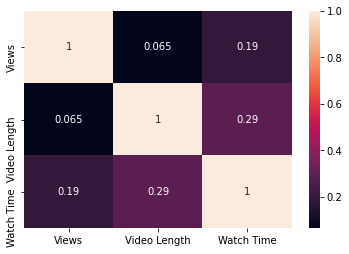

In [ ]:
youtube_studio_df
engagement = youtube_studio_df[['Views','Video Length','Watch Time']]
sns.heatmap(engagement.corr(),annot=True)

### 2.2.2: Views
#### 2.2.2.1: Top 20 Videos during 01/01/2020-3/25/2021


In [ ]:
views_df = youtube_studio_df.groupby(['Video Title','Publish Date'])['Views'].sum().reset_index(name='views').sort_values(by=['views'], ascending=False)
views_df = views_df.head(20)
views_df

,Video Title,Publish Date,views
253,Women in Science Symposium 2012 Closing Keynot...,2012-08-13,4669
217,The Origins of Genus Homo,2018-06-18,4270
21,Biomechanics of Running: The Science of Moveme...,2014-09-13,2779
123,Neutrino 2020 Physics Slam!,2020-07-02,1675
79,Forensic Genomic Technologies: New Frontiers B...,2020-06-26,1299
84,Head Banging: How Music and Concussions Impact...,2018-10-04,1198
208,The Heart of Marine Biodiversity Saving the V...,2016-10-12,1150
209,The Heart of Marine Biodiversity: Saving the V...,2016-09-29,1040
144,Program: The Art of Logic with Dr. Eugenia Cheng,2020-01-10,1011
228,The Secret Lives of Female Chimpanzees,2016-08-18,1008


Text(0, 0.5, 'Lifetime Views')

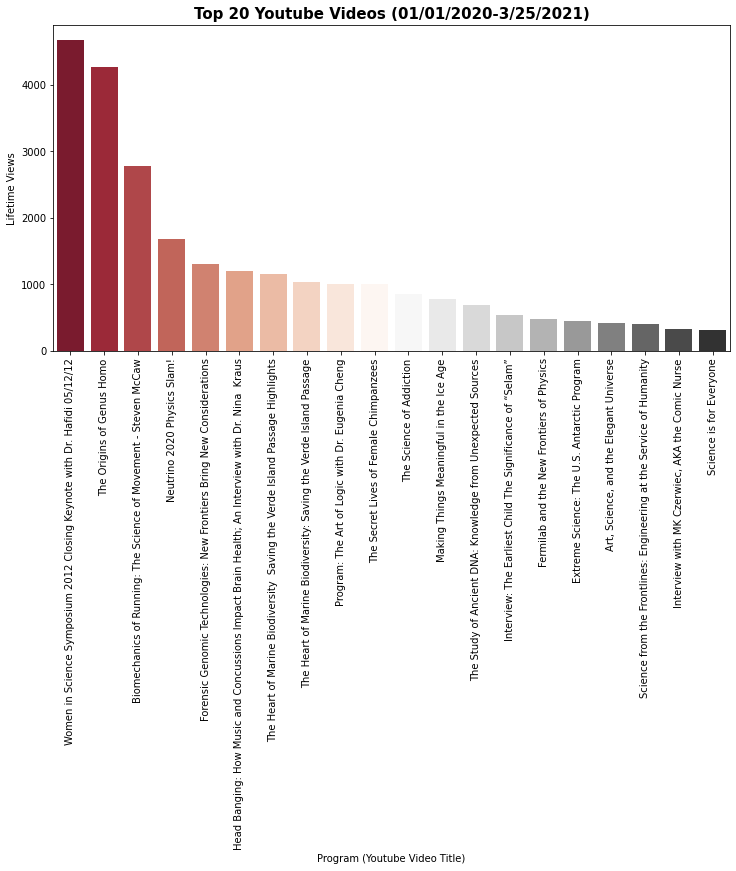

In [ ]:
fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(nrows=1, ncols=2,
                       height_ratios=[6], 
                       width_ratios=[10, 5])

ax = plt.subplot(gs[0])
sns.barplot(x = "Video Title",y = "views",data = views_df,ax=ax, palette="RdGy")
ax.set_xticklabels(views_df['Video Title'], rotation='90')
ax.set_title('Top 20 Youtube Videos (01/01/2020-3/25/2021)', fontsize=15, fontweight='bold')
ax.set_xlabel('Program (Youtube Video Title)')
ax.set_ylabel('Lifetime Views')

Text(0, 0.5, 'Lifetime Views')

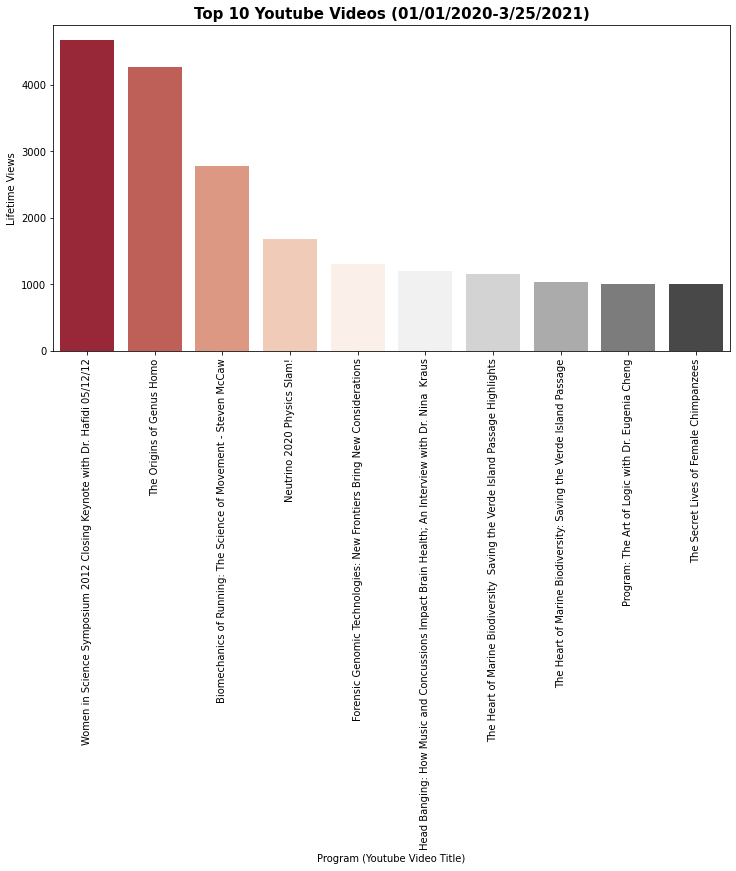

In [ ]:
views_df5 = views_df.copy().head(10)

fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(nrows=1, ncols=2,
                       height_ratios=[6], 
                       width_ratios=[10, 5])

ax = plt.subplot(gs[0])
sns.barplot(x = "Video Title",y = "views",data = views_df5,ax=ax, palette="RdGy")
ax.set_xticklabels(views_df['Video Title'], rotation='90')
ax.set_title('Top 10 Youtube Videos (01/01/2020-3/25/2021)', fontsize=15, fontweight='bold')
ax.set_xlabel('Program (Youtube Video Title)')
ax.set_ylabel('Lifetime Views')

#### 2.2.2.2: Total Views by month (01/01/2020-12/31/2020)

In [ ]:
month_df = youtube_studio_df[(youtube_studio_df['Update Date']!= '2021-03-01') &(youtube_studio_df['Update Date']!= '2021-04-01')&(youtube_studio_df['Update Date']!= '2021-02-01')]
month_df['Month'] = month_df['Update Date'].dt.month - 1
month_df.loc[month_df['Month']==0,'Month'] =12
month_view_df = month_df.groupby(['Month'])['Views'].sum().reset_index(name='Total Views').sort_values(by=['Total Views'], ascending=False)

In [ ]:
month_view_df

,Month,Total Views
4,5,5234
0,1,4352
5,6,3866
1,2,3691
11,12,3541
8,9,3212
6,7,3093
9,10,2997
10,11,2962
7,8,2873


Text(0.5, 1.0, 'Views by Month')

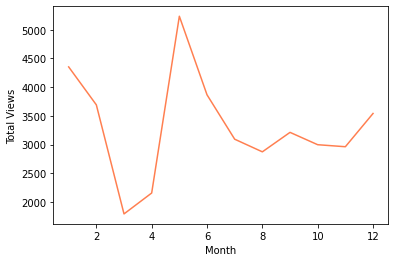

In [ ]:
sns.lineplot(data=month_view_df, x="Month", y="Total Views",color="coral")
ax.set_title('Views by Month', fontsize=15, fontweight='bold')

#### 2.2.2.3 Top 5 Video by month

In [ ]:
update_list = [date for date in month_df['Update Date']]
update_list = set(update_list)

video_month_dataframes = []
for date in update_list:
  df = month_df[month_df['Update Date']==date].sort_values(by='Views', ascending=False).head(5)
  video_month_dataframes.append(df)
video_month_df = pd.concat(video_month_dataframes)
video_month_df = video_month_df[['Video Title','Views','Update Date','Publish Date']]
pd.set_option('display.max_rows', 122)
video_month_df = video_month_df.sort_values(['Update Date', 'Views'], ascending=[True, False])
video_month_df

,Video Title,Views,Update Date,Publish Date
2374,Biomechanics of Running: The Science of Moveme...,196,2020-01-31,2014-09-13
2375,The Origins of Genus Homo,123,2020-01-31,2018-06-18
2376,The Heart of Marine Biodiversity Saving the V...,100,2020-01-31,2016-10-12
2377,The Heart of Marine Biodiversity: Saving the V...,85,2020-01-31,2016-09-29
2378,The Science of Addiction,80,2020-01-31,2016-03-24
2231,Biomechanics of Running: The Science of Moveme...,166,2020-02-29,2014-09-13
2232,The Heart of Marine Biodiversity Saving the V...,160,2020-02-29,2016-10-12
2233,The Origins of Genus Homo,127,2020-02-29,2018-06-18
2234,The Heart of Marine Biodiversity: Saving the V...,83,2020-02-29,2016-09-29
2235,The Science of Addiction,78,2020-02-29,2016-03-24


### 2.2.3: Watchtimes
#### 2.2.3.1 Watchtimes distribution by month

(0.0, 15.0)

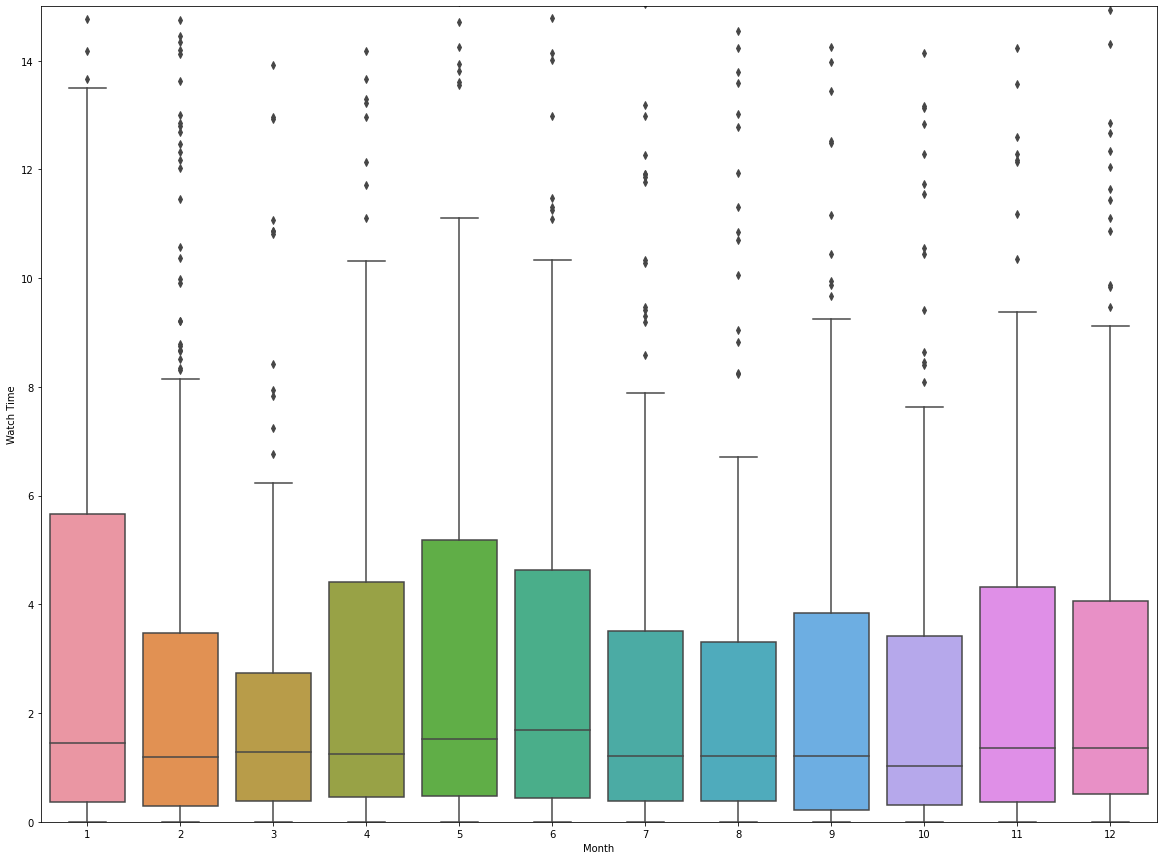

In [ ]:
ax = plt.figure(figsize=(20,15))
watchtime_df = month_df.copy()
watchtime_df['Watch Time'] = watchtime_df['Watch Time']/(60)     # convert to minutes
ax = sns.boxplot(x="Month", y="Watch Time", data = watchtime_df)
ax.set_ylim(0,15)